## 과제1

In [7]:
import pandas as pd

# Load the necessary datasets
try:
    df_customers = pd.read_csv("olist_customers_dataset.csv")
    df_orders = pd.read_csv("olist_orders_dataset.csv")
    df_order_items = pd.read_csv("olist_order_items_dataset.csv")

    # Merge the DataFrames
    # 1. Merge orders and order_items on 'order_id'
    df_merged = pd.merge(df_orders, df_order_items, on='order_id', how='inner')

    # 2. Merge the result with customers on 'customer_id'
    df_final = pd.merge(df_merged, df_customers, on='customer_id', how='inner')

    # Inspect the final merged DataFrame
    print("--- 최종 병합 데이터프레임 정보 ---")
    df_final.info()
    print("\n--- 최종 병합 데이터프레임 샘플 ---")
    print(df_final.head())

    # Save the final dataframe to a csv for next steps.
    df_final.to_csv("df_final.csv", index=False)

except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure the files are uploaded correctly.")

--- 최종 병합 데이터프레임 정보 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112650 non-null  object 
 1   customer_id                    112650 non-null  object 
 2   order_status                   112650 non-null  object 
 3   order_purchase_timestamp       112650 non-null  object 
 4   order_approved_at              112635 non-null  object 
 5   order_delivered_carrier_date   111456 non-null  object 
 6   order_delivered_customer_date  110196 non-null  object 
 7   order_estimated_delivery_date  112650 non-null  object 
 8   order_item_id                  112650 non-null  int64  
 9   product_id                     112650 non-null  object 
 10  seller_id                      112650 non-null  object 
 11  shipping_limit_date            112650 non-null  object 
 12  price 

In [8]:
import pandas as pd
import datetime as dt

# Load the merged data
try:
    df_final = pd.read_csv("df_final.csv")

    # 1. Convert 'order_purchase_timestamp' to datetime
    df_final['order_purchase_timestamp'] = pd.to_datetime(df_final['order_purchase_timestamp'])

    # 2. Calculate a total 'monetary' value for each item
    df_final['total_monetary_value'] = df_final['price'] + df_final['freight_value']

    # Set a reference date for Recency calculation (1 day after the latest purchase date)
    latest_date = df_final['order_purchase_timestamp'].max() + dt.timedelta(days=1)

    # Calculate RFM metrics
    rfm_df = df_final.groupby('customer_unique_id').agg({
        'order_purchase_timestamp': lambda date: (latest_date - date.max()).days,
        'order_id': 'nunique',
        'total_monetary_value': 'sum'
    }).reset_index()

    # Rename the columns for clarity
    rfm_df.columns = ['customer_unique_id', 'Recency', 'Frequency', 'Monetary']

    # Print the first few rows of the RFM DataFrame
    print("--- RFM 지표 계산 결과 ---")
    print(rfm_df.head())

    # Save the RFM DataFrame to a CSV file
    rfm_df.to_csv("rfm_df.csv", index=False)

except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure the files are uploaded or generated correctly.")

--- RFM 지표 계산 결과 ---
                 customer_unique_id  Recency  Frequency  Monetary
0  0000366f3b9a7992bf8c76cfdf3221e2      116          1    141.90
1  0000b849f77a49e4a4ce2b2a4ca5be3f      119          1     27.19
2  0000f46a3911fa3c0805444483337064      542          1     86.22
3  0000f6ccb0745a6a4b88665a16c9f078      326          1     43.62
4  0004aac84e0df4da2b147fca70cf8255      293          1    196.89


In [9]:
import pandas as pd
import numpy as np

# Load the previously generated DataFrames
try:
    df_customers = pd.read_csv("olist_customers_dataset.csv")
    rfm_df = pd.read_csv("rfm_df.csv")

    # RFM Scoring using quantiles (quartiles)
    # Recency: Lower values are better (more recent), so score should be inverted.
    rfm_df['R_score'] = pd.qcut(rfm_df['Recency'], 4, labels=[4, 3, 2, 1])
    # Frequency: Higher values are better.
    rfm_df['F_score'] = pd.qcut(rfm_df['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
    # Monetary: Higher values are better.
    rfm_df['M_score'] = pd.qcut(rfm_df['Monetary'], 4, labels=[1, 2, 3, 4])

    # Combine RFM scores to create a segment score string
    rfm_df['RFM_score'] = rfm_df['R_score'].astype(str) + rfm_df['F_score'].astype(str) + rfm_df['M_score'].astype(str)

    # Define a function to map RFM scores to segments
    def rfm_segment(score):
        if score in ['444', '443', '434', '344', '334', '433']:
            return 'Best Customers'
        elif score in ['422', '322', '412', '421', '321']:
            return 'New & Active Customers'
        elif score in ['233', '234', '243', '244', '144', '134']:
            return 'Loyal Customers'
        elif score in ['111', '112', '121', '211']:
            return 'At-Risk & Churning Customers'
        elif score in ['114', '124', '133', '143', '214', '224']:
            return 'Can\'t Lose Them'
        else:
            return 'Other'

    # Apply the segmentation function
    rfm_df['Segment'] = rfm_df['RFM_score'].apply(rfm_segment)

    # Merge customer state information for regional analysis
    df_customers_unique = df_customers.drop_duplicates(subset='customer_unique_id')
    rfm_df = pd.merge(rfm_df, df_customers_unique[['customer_unique_id', 'customer_state']], on='customer_unique_id', how='left')

    # Print a sample of the segmented DataFrame
    print("--- 고객 세분화 및 RFM 점수 계산 결과 ---")
    print(rfm_df[['customer_unique_id', 'Recency', 'Frequency', 'Monetary', 'RFM_score', 'Segment', 'customer_state']].head(10))

    # Save the segmented RFM DataFrame
    rfm_df.to_csv("rfm_segmented.csv", index=False)

except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure the files are uploaded or generated correctly.")

--- 고객 세분화 및 RFM 점수 계산 결과 ---
                 customer_unique_id  Recency  Frequency  Monetary RFM_score  \
0  0000366f3b9a7992bf8c76cfdf3221e2      116          1    141.90       413   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      119          1     27.19       411   
2  0000f46a3911fa3c0805444483337064      542          1     86.22       112   
3  0000f6ccb0745a6a4b88665a16c9f078      326          1     43.62       211   
4  0004aac84e0df4da2b147fca70cf8255      293          1    196.89       214   
5  0004bd2a26a76fe21f786e4fbd80607f      151          1    166.98       313   
6  00050ab1314c0e55a6ca13cf7181fecf      136          1     35.38       311   
7  00053a61a98854899e70ed204dd4bafe      187          1    419.18       314   
8  0005e1862207bf6ccc02e4228effd9a0      548          1    150.12       113   
9  0005ef4cd20d2893f0d9fbd94d3c0d97      175          1    129.76       313   

                        Segment customer_state  
0                         Other             SP  
1 

--- 고객 세그먼트별 분포 (%) ---
Segment
Other                           57.386292
Best Customers                   9.922448
Loyal Customers                  9.460281
Can't Lose Them                  8.832530
New & Active Customers           7.848459
At-Risk & Churning Customers     6.549990
Name: proportion, dtype: float64


--- 세그먼트별 평균 RFM 값 ---
                              Recency  Frequency  Monetary
Segment                                                   
At-Risk & Churning Customers   415.85       1.00     53.77
Best Customers                 100.38       1.15    315.34
Can't Lose Them                400.44       1.02    312.30
Loyal Customers                342.36       1.12    313.36
New & Active Customers         106.45       1.00     67.02
Other                          227.04       1.01    119.78


--- 지역(주)별 고객 세그먼트 분포 (%) ---
Segment         At-Risk & Churning Customers  Best Customers  Can't Lose Them  \
customer_state                                                           

C:\Users\user\AppData\Local\Temp\ipykernel_13236\592925481.py:36: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


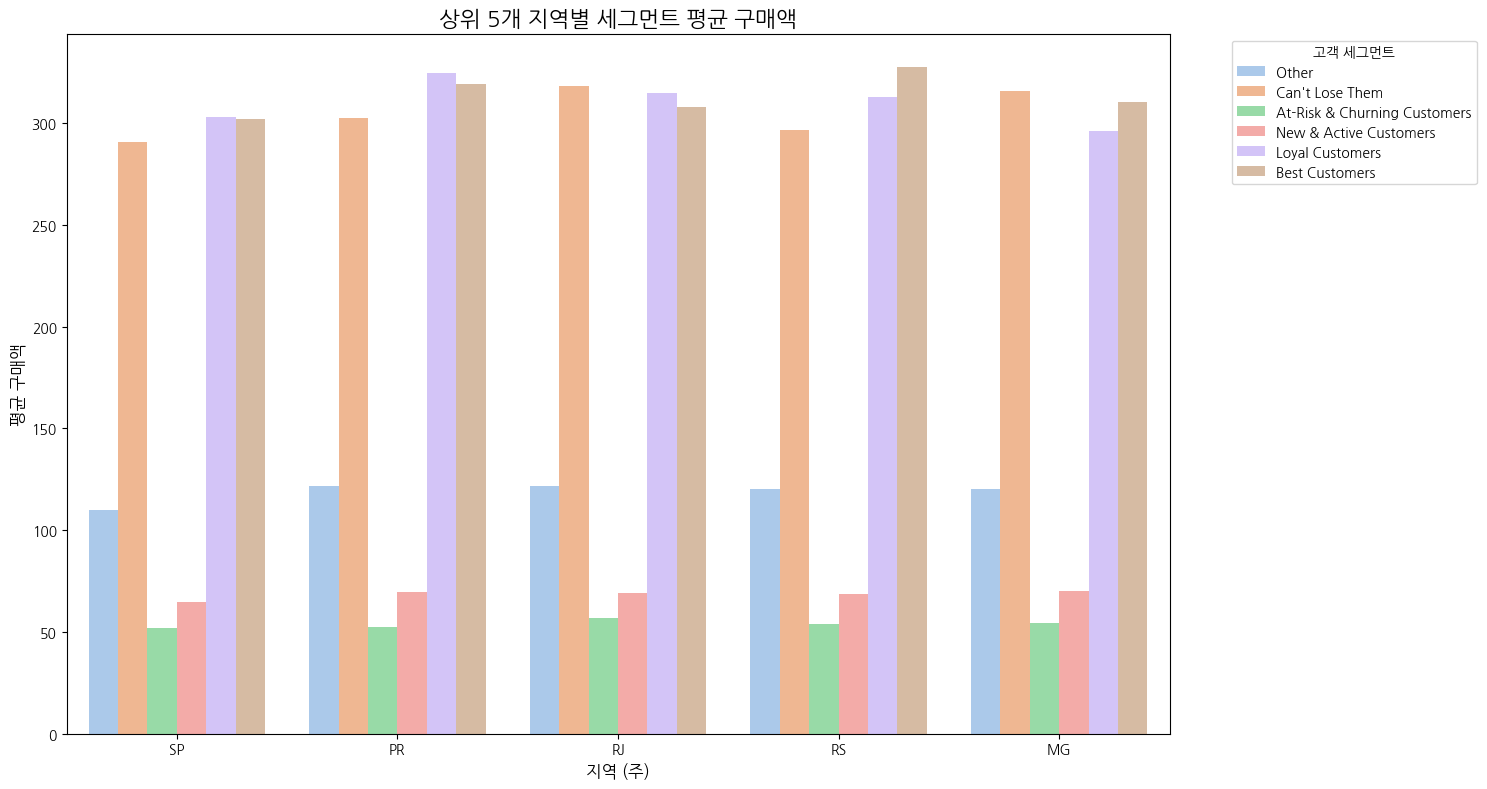

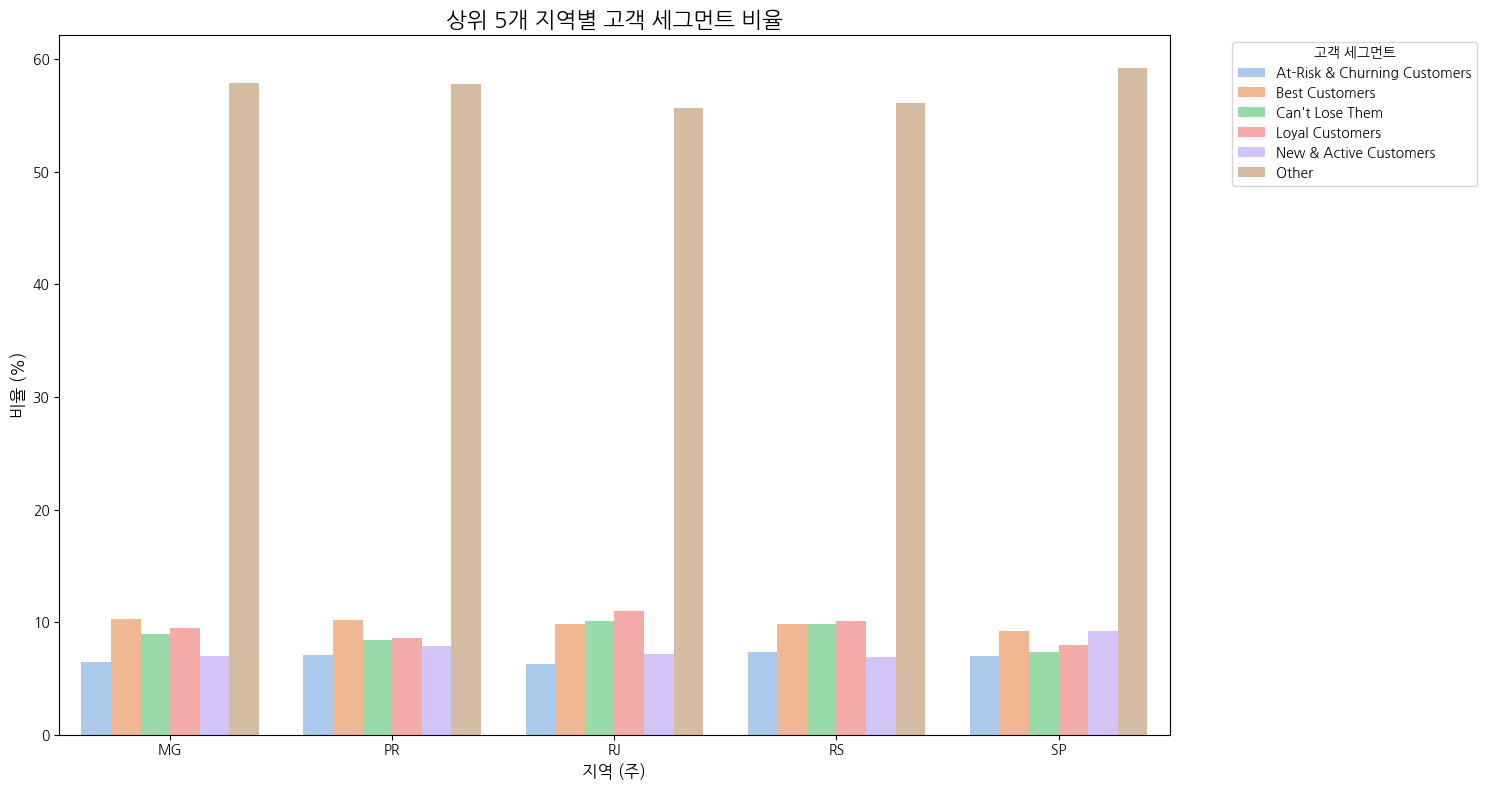

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the segmented RFM data
try:
    rfm_segmented = pd.read_csv("rfm_segmented.csv")

    # 1. 고객 세그먼트별 분포 분석
    segment_counts = rfm_segmented['Segment'].value_counts(normalize=True) * 100
    print("--- 고객 세그먼트별 분포 (%) ---")
    print(segment_counts)
    print("\n")

    # 2. 세그먼트별 평균 RFM 값 분석
    segment_metrics = rfm_segmented.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].mean().round(2)
    print("--- 세그먼트별 평균 RFM 값 ---")
    print(segment_metrics)
    print("\n")

    # 3. 지역별 RFM 세그먼트 분포 분석
    regional_segments = rfm_segmented.groupby(['customer_state', 'Segment']).size().unstack(fill_value=0)
    # Calculate percentage within each state
    regional_segments_perc = regional_segments.div(regional_segments.sum(axis=1), axis=0) * 100
    print("--- 지역(주)별 고객 세그먼트 분포 (%) ---")
    print(regional_segments_perc.head())
    print("\n")

    # 시각화를 위해 상위 5개 주만 선택
    top_5_states = rfm_segmented['customer_state'].value_counts().head(5).index
    df_top_states = rfm_segmented[rfm_segmented['customer_state'].isin(top_5_states)]

    # Plot RFM distribution by state (파스텔톤으로 변경)
    plt.figure(figsize=(15, 8))
    sns.barplot(
        data=df_top_states,
        x='customer_state',
        y='Monetary',
        hue='Segment',
        estimator=np.mean,
        ci=None,
        palette='pastel' # 팔레트를 'pastel'로 변경
    )
    plt.title('상위 5개 지역별 세그먼트 평균 구매액', fontsize=16)
    plt.xlabel('지역 (주)', fontsize=12)
    plt.ylabel('평균 구매액', fontsize=12)
    plt.xticks(rotation=0)
    plt.legend(title='고객 세그먼트', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('regional_monetary_distribution_pastel.png') # 파일 이름 변경

    # Plot segment distribution by state (파스텔톤으로 변경)
    df_segment_counts = df_top_states.groupby(['customer_state', 'Segment']).size().reset_index(name='count')
    total_counts = df_segment_counts.groupby('customer_state')['count'].sum()
    df_segment_counts['percentage'] = df_segment_counts.apply(lambda row: (row['count'] / total_counts[row['customer_state']]) * 100, axis=1)

    plt.figure(figsize=(15, 8))
    sns.barplot(
        data=df_segment_counts,
        x='customer_state',
        y='percentage',
        hue='Segment',
        palette='pastel' # 팔레트를 'pastel'로 변경
    )
    plt.title('상위 5개 지역별 고객 세그먼트 비율', fontsize=16)
    plt.xlabel('지역 (주)', fontsize=12)
    plt.ylabel('비율 (%)', fontsize=12)
    plt.xticks(rotation=0)
    plt.legend(title='고객 세그먼트', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('regional_segment_distribution_pastel.png') # 파일 이름 변경

except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure the files are uploaded or generated correctly.")

C:\Users\user\AppData\Local\Temp\ipykernel_13236\3930054965.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='pastel') # 팔레트를 'pastel'로 변경


RFM 분석 및 시각화가 완료되었습니다. 'rfm_segmentation_pastel.png' 파일이 저장되었습니다.

세그먼트별 고객 수:
Segment
Loyal Customers       30860
Potential Loyalist    23053
Champions             15374
At Risk               15234
About to Sleep         7679
Hibernating            3895
Name: count, dtype: int64


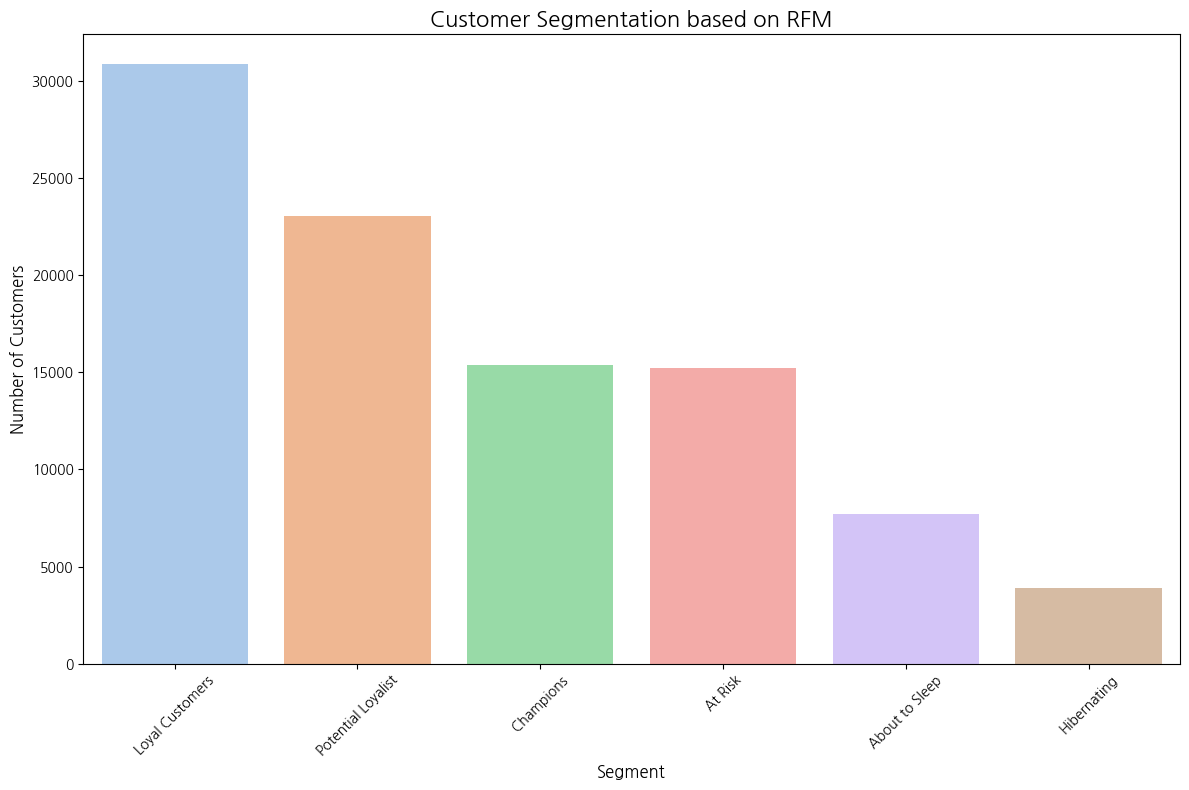

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# 데이터 불러오기
orders = pd.read_csv('olist_orders_dataset.csv')
customers = pd.read_csv('olist_customers_dataset.csv')
payments = pd.read_csv('olist_order_payments_dataset.csv')

# 데이터 병합
df = orders.merge(customers, on='customer_id')
df = df.merge(payments, on='order_id')

# 필요한 컬럼만 선택하고 데이터 타입 변환
df = df[['customer_unique_id', 'order_id', 'order_purchase_timestamp', 'payment_value']]
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

# RFM 계산을 위한 기준 날짜 설정 (마지막 구매일 + 1일)
snapshot_date = df['order_purchase_timestamp'].max() + dt.timedelta(days=1)

# RFM 값 계산
rfm_data = df.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (snapshot_date - x.max()).days,
    'order_id': 'count',
    'payment_value': 'sum'
})

# 컬럼 이름 변경
rfm_data.rename(columns={'order_purchase_timestamp': 'Recency',
                         'order_id': 'Frequency',
                         'payment_value': 'Monetary'}, inplace=True)

# RFM 점수 계산 (5분위수 기준)
r_labels = range(5, 0, -1)
f_labels = range(1, 6)
m_labels = range(1, 6)

r_quartiles = pd.qcut(rfm_data['Recency'], q=5, labels=r_labels)
f_quartiles = pd.qcut(rfm_data['Frequency'].rank(method='first'), q=5, labels=f_labels)
m_quartiles = pd.qcut(rfm_data['Monetary'], q=5, labels=m_labels)

rfm_data = rfm_data.assign(R=r_quartiles, F=f_quartiles, M=m_quartiles)

# RFM 세그먼트 정의 함수
def rfm_segment(df):
    if df['R'] >= 4 and df['F'] >= 4:
        return 'Champions'
    elif df['R'] >= 2 and df['F'] >= 3:
        return 'Loyal Customers'
    elif df['R'] >= 3 and df['F'] >= 1 and df['F'] <= 3:
        return 'Potential Loyalist'
    elif df['R'] >= 4 and df['F'] == 1:
        return 'New Customers'
    elif df['R'] >= 3 and df['F'] == 1:
        return 'Promising'
    elif df['R'] >= 3 and df['F'] >= 3:
        return 'Need Attention'
    elif df['R'] >= 2 and df['R'] <= 3 and df['F'] >= 1 and df['F'] <= 2:
        return 'About to Sleep'
    elif df['R'] <= 2 and df['F'] >= 2:
        return 'At Risk'
    elif df['R'] <= 1 and df['F'] >= 4:
        return "Can't Lose Them"
    else:
        return 'Hibernating'

rfm_data['Segment'] = rfm_data.apply(rfm_segment, axis=1)

# 세그먼트별 고객 수 계산 및 시각화
segment_counts = rfm_data['Segment'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='pastel') # 팔레트를 'pastel'로 변경
plt.title('Customer Segmentation based on RFM', fontsize=16)
plt.xlabel('Segment', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('rfm_segmentation_pastel.png') # 파일 이름 변경

print("RFM 분석 및 시각화가 완료되었습니다. 'rfm_segmentation_pastel.png' 파일이 저장되었습니다.")
print("\n세그먼트별 고객 수:")
print(segment_counts)

C:\Users\user\AppData\Local\Temp\ipykernel_27116\1671927909.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='pastel')


RFM 분석 및 시각화가 완료되었습니다. 'rfm_segmentation_pastel.png' 파일이 저장되었습니다.

세그먼트별 고객 수:
Segment
Others                          46180
Loyal Customers                 17757
At-Risk & Churning Customers     9538
New & Active Customers           9299
Can't Lose Them                  6662
Best Customers                   6659
Name: count, dtype: int64


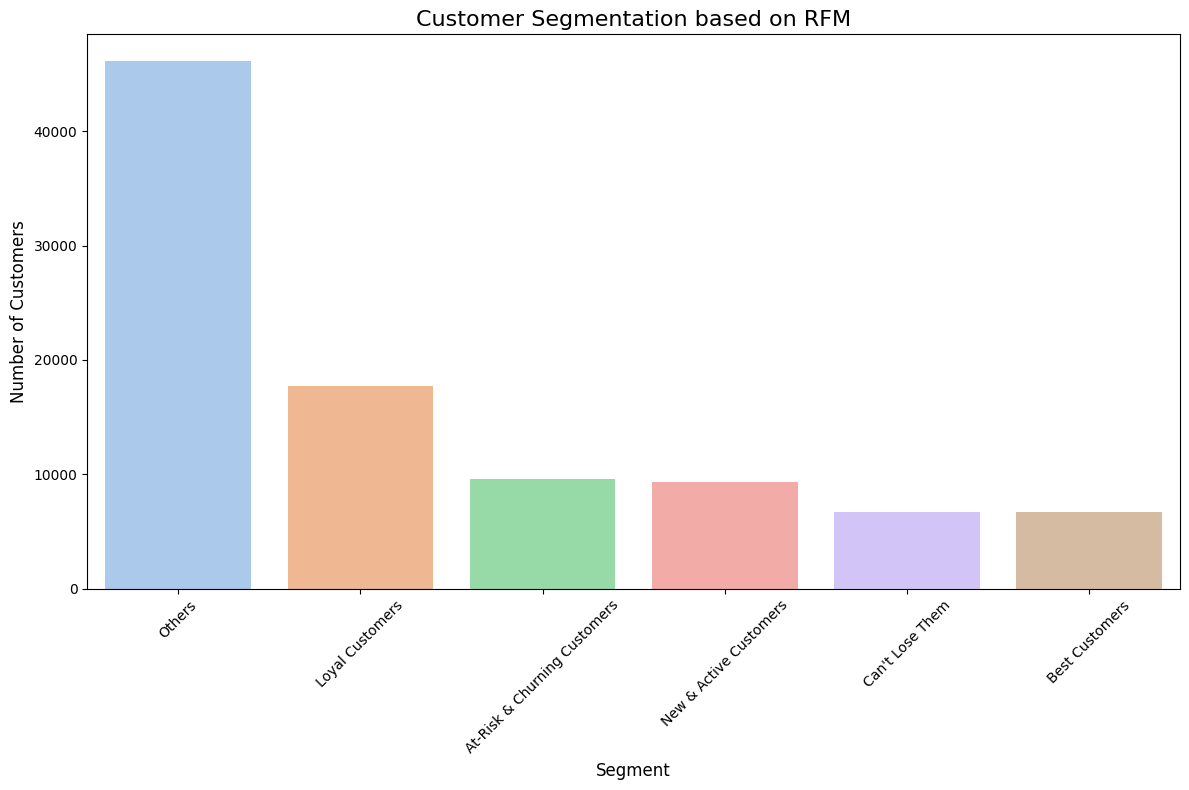

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Load the necessary datasets from the user's previous steps
orders = pd.read_csv('olist_orders_dataset.csv')
customers = pd.read_csv('olist_customers_dataset.csv')
payments = pd.read_csv('olist_order_payments_dataset.csv')

# Data merging and RFM calculation as in the user's previous code
df = orders.merge(customers, on='customer_id')
df = df.merge(payments, on='order_id')

df = df[['customer_unique_id', 'order_id', 'order_purchase_timestamp', 'payment_value']]
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

snapshot_date = df['order_purchase_timestamp'].max() + dt.timedelta(days=1)

rfm_data = df.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (snapshot_date - x.max()).days,
    'order_id': 'count',
    'payment_value': 'sum'
})

rfm_data.rename(columns={'order_purchase_timestamp': 'Recency',
                         'order_id': 'Frequency',
                         'payment_value': 'Monetary'}, inplace=True)

r_labels = range(5, 0, -1)
f_labels = range(1, 6)
m_labels = range(1, 6)

rfm_data['R_Score'] = pd.qcut(rfm_data['Recency'], q=5, labels=r_labels, duplicates='drop')
rfm_data['F_Score'] = pd.qcut(rfm_data['Frequency'].rank(method='first'), q=5, labels=f_labels, duplicates='drop')
rfm_data['M_Score'] = pd.qcut(rfm_data['Monetary'], q=5, labels=m_labels, duplicates='drop')

def rfm_segment_new(row):
    r = row['R_Score']
    f = row['F_Score']
    m = row['M_Score']
    
    # Using the segmentation logic from the previous conversation
    if r in [4, 5] and f in [4, 5] and m in [4, 5]:
        return 'Best Customers'
    elif r in [2, 3, 4] and f in [3, 4, 5] and m in [3, 4, 5]:
        return 'Loyal Customers'
    elif r in [4, 5] and f in [1, 2] and m in [1, 2, 3]:
        return 'New & Active Customers'
    elif r in [1, 2] and f in [3, 4, 5] and m in [3, 4, 5]:
        return "Can't Lose Them"
    elif r in [1, 2, 3] and f in [1, 2] and m in [1, 2]:
        return 'At-Risk & Churning Customers'
    else:
        return 'Others'

rfm_data['Segment'] = rfm_data.apply(rfm_segment_new, axis=1)

# 세그먼트별 고객 수 계산 및 시각화
segment_counts = rfm_data['Segment'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='pastel')
plt.title('Customer Segmentation based on RFM', fontsize=16)
plt.xlabel('Segment', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('rfm_segmentation_pastel.png')

print("RFM 분석 및 시각화가 완료되었습니다. 'rfm_segmentation_pastel.png' 파일이 저장되었습니다.")
print("\n세그먼트별 고객 수:")
print(segment_counts)

## 과제2

총 주문 수: 99992
평균 배송일수: 12.100015463120458
중앙값 배송일수: 10.0
정시배송률: 0.904492359388751
지연일수 vs 리뷰점수 상관계수: -0.266763661637995
회귀식: 리뷰 = nan * 지연일수 + nan
  customer_state  orders  mean_delivery_days  median_delivery_days  \
0             AC      81           20.637500                  18.0   
1             AL     417           24.029925                  22.0   
2             AM     149           25.945205                  25.0   
3             AP      68           26.731343                  24.0   
4             BA    3397           18.886954                  16.0   

   on_time_rate  avg_review_score  
0      0.950617          4.049383  
1      0.755396          3.751208  
2      0.953020          4.183673  
3      0.955882          4.194030  
4      0.845746          3.860888  


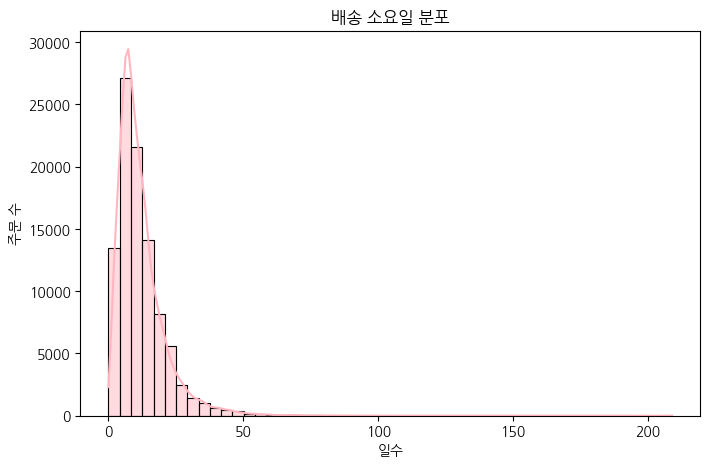

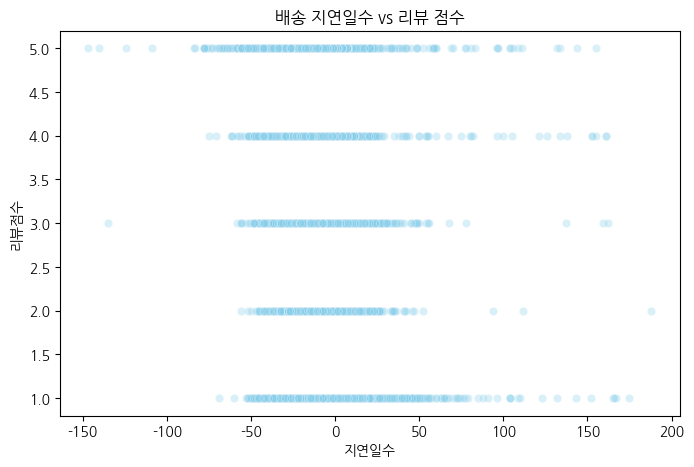

C:\Users\user\AppData\Local\Temp\ipykernel_13236\2740951405.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


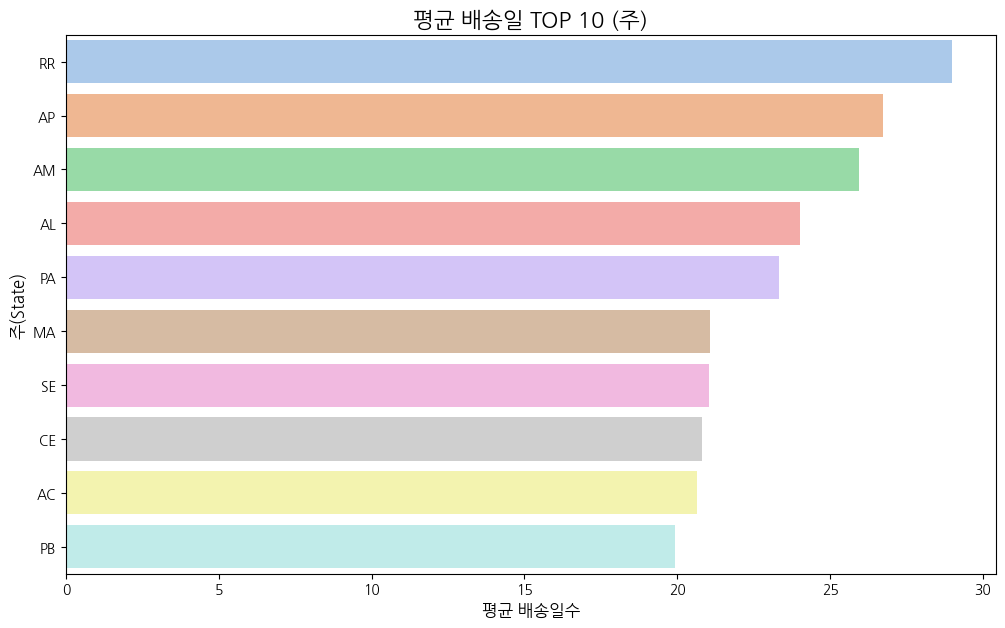

C:\Users\user\AppData\Local\Temp\ipykernel_13236\2740951405.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


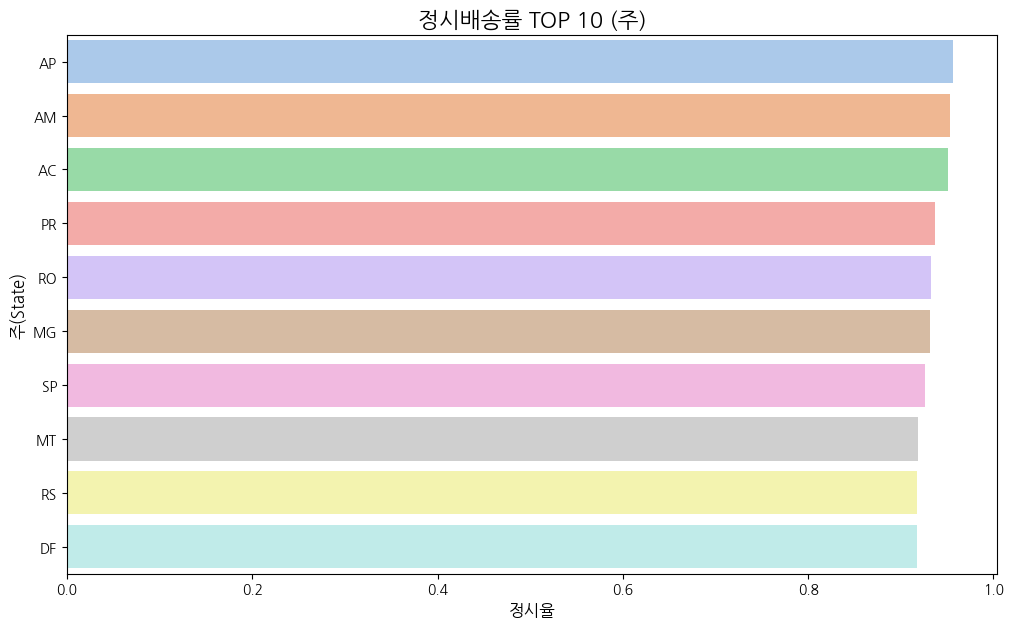

C:\Users\user\AppData\Local\Temp\ipykernel_13236\2740951405.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="customer_state", y="delivery_days", data=top_10_order_df, palette="pastel")


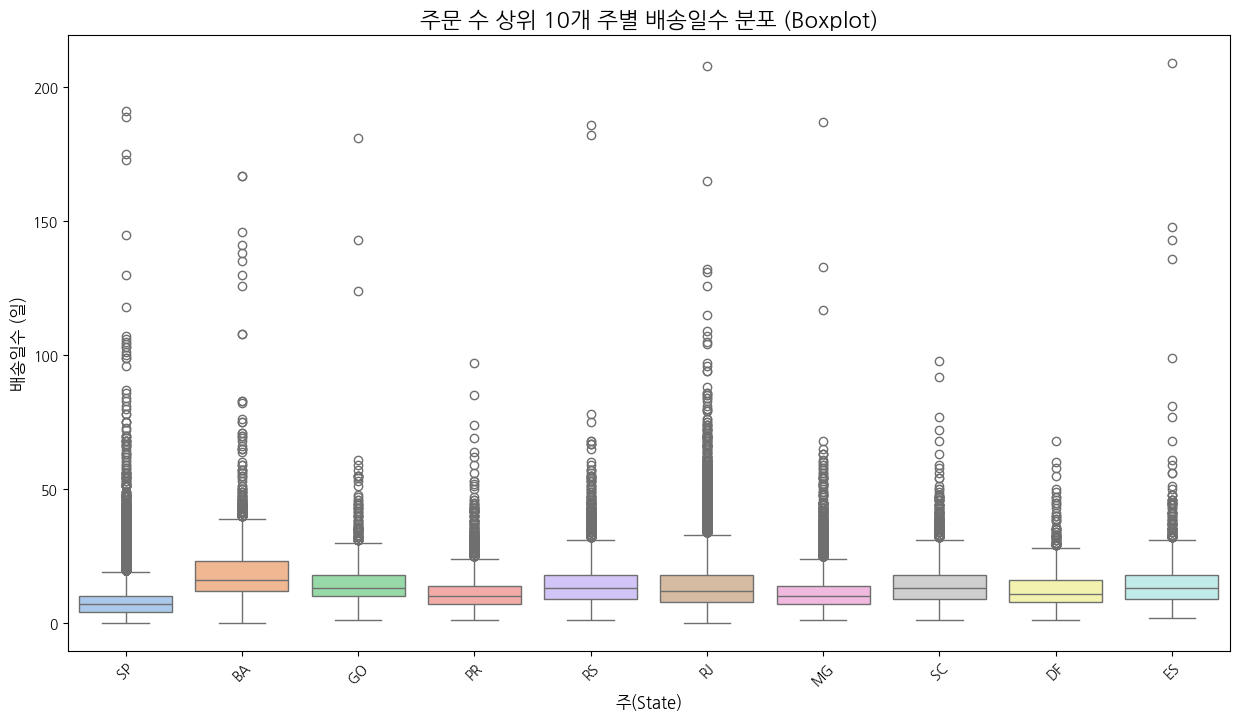

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------
# 1. 데이터 로드
# ---------------------
orders = pd.read_csv("olist_orders_dataset.csv", parse_dates=["order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date", "order_delivered_customer_date", "order_estimated_delivery_date"])
order_items = pd.read_csv("olist_order_items_dataset.csv", parse_dates=["shipping_limit_date"])
reviews = pd.read_csv("olist_order_reviews_dataset.csv", parse_dates=["review_creation_date"])
customers = pd.read_csv("olist_customers_dataset.csv")

# ---------------------
# 2. 주문-배송 리드타임 계산
# ---------------------
# 주문-리뷰 데이터 결합
order_df = orders.merge(reviews, on="order_id", how="left", suffixes=("", "_review"))
order_df = order_df.merge(customers, on="customer_id", how="left")

# 실제 배송일수 & 예상 대비 차이
order_df["delivery_days"] = (order_df["order_delivered_customer_date"] - order_df["order_purchase_timestamp"]).dt.days
order_df["delay_vs_estimate_days"] = (order_df["order_delivered_customer_date"] - order_df["order_estimated_delivery_date"]).dt.days

# 정시 배송 여부
order_df["on_time"] = order_df["delay_vs_estimate_days"] <= 0

# ---------------------
# 3. KPI 집계
# ---------------------
orders_total = len(order_df)
mean_delivery_days = order_df["delivery_days"].mean()
median_delivery_days = order_df["delivery_days"].median()
on_time_rate = order_df["on_time"].mean()

print("총 주문 수:", orders_total)
print("평균 배송일수:", mean_delivery_days)
print("중앙값 배송일수:", median_delivery_days)
print("정시배송률:", on_time_rate)

# ---------------------
# 4. 리뷰 점수와 지연일수 관계
# ---------------------
corr = order_df[["delay_vs_estimate_days","review_score"]].corr().iloc[0,1]
print("지연일수 vs 리뷰점수 상관계수:", corr)

# 단순 회귀선 추정
x = order_df["delay_vs_estimate_days"].dropna()
y = order_df.loc[x.index, "review_score"]
a, b = np.polyfit(x, y, 1)
print(f"회귀식: 리뷰 = {a:.3f} * 지연일수 + {b:.3f}")

# ---------------------
# 5. 주(State)별 배송 성과 집계
# ---------------------
state_perf = order_df.groupby("customer_state").agg(
    orders=("order_id","count"),
    mean_delivery_days=("delivery_days","mean"),
    median_delivery_days=("delivery_days","median"),
    on_time_rate=("on_time","mean"),
    avg_review_score=("review_score","mean")
).reset_index()

print(state_perf.head())

# ---------------------
# 6. 시각화
# ---------------------
# 전체 그래프에 파스텔톤 팔레트 적용
sns.set_palette('pastel')

### Seaborn을 활용하여 그래프 색상 개선

# 배송 소요일 분포
plt.figure(figsize=(8,5))
sns.histplot(data=order_df, x="delivery_days", bins=50, kde=True, color='lightpink')
plt.title("배송 소요일 분포")
plt.xlabel("일수")
plt.ylabel("주문 수")
plt.show()

# 배송 지연일수 vs 리뷰 점수
plt.figure(figsize=(8,5))
sns.scatterplot(data=order_df, x="delay_vs_estimate_days", y="review_score", alpha=0.3, color='skyblue')
plt.title("배송 지연일수 vs 리뷰 점수")
plt.xlabel("지연일수")
plt.ylabel("리뷰점수")
plt.show()

# 평균 배송일 TOP 10 (주) 그래프
plt.figure(figsize=(12, 7))
top_10_delivery_states = state_perf.sort_values("mean_delivery_days", ascending=False).head(10)
sns.barplot(
    x="mean_delivery_days",
    y="customer_state",
    data=top_10_delivery_states,
    palette="pastel"
)
plt.title("평균 배송일 TOP 10 (주)", fontsize=16)
plt.xlabel("평균 배송일수", fontsize=12)
plt.ylabel("주(State)", fontsize=12)
plt.show()

# 정시배송률 TOP 10 (주)
plt.figure(figsize=(12, 7))
top_10_on_time_states = state_perf.sort_values("on_time_rate", ascending=False).head(10)
sns.barplot(
    x="on_time_rate",
    y="customer_state",
    data=top_10_on_time_states,
    palette="pastel"
)
plt.title("정시배송률 TOP 10 (주)", fontsize=16)
plt.xlabel("정시율", fontsize=12)
plt.ylabel("주(State)", fontsize=12)
plt.show()

# 주문 수 상위 10개 주별 배송일수 분포 (Boxplot)
top_10_order_states = order_df["customer_state"].value_counts().head(10).index.tolist()
top_10_order_df = order_df[order_df["customer_state"].isin(top_10_order_states)]

plt.figure(figsize=(15, 8))
sns.boxplot(x="customer_state", y="delivery_days", data=top_10_order_df, palette="pastel")
plt.title("주문 수 상위 10개 주별 배송일수 분포 (Boxplot)", fontsize=16)
plt.xlabel("주(State)", fontsize=12)
plt.ylabel("배송일수 (일)", fontsize=12)
plt.xticks(rotation=45)
plt.show()

## 과제3

In [22]:
import pandas as pd

# Load the necessary datasets
try:
    df_orders = pd.read_csv("olist_orders_dataset.csv")
    df_order_items = pd.read_csv("olist_order_items_dataset.csv")
    df_products = pd.read_csv("olist_products_dataset.csv")
    df_translation = pd.read_csv("product_category_name_translation.csv")

    # Merge the DataFrames
    # 1. Merge orders and order_items on 'order_id'
    df_merged_1 = pd.merge(df_orders, df_order_items, on='order_id', how='inner')

    # 2. Merge the result with products on 'product_id'
    df_merged_2 = pd.merge(df_merged_1, df_products, on='product_id', how='inner')

    # 3. Merge the result with product category translations
    df_final = pd.merge(df_merged_2, df_translation, on='product_category_name', how='inner')

    # Convert date column to datetime
    df_final['order_purchase_timestamp'] = pd.to_datetime(df_final['order_purchase_timestamp'])

    # Print a summary of the merged DataFrame
    print("--- 최종 병합 데이터프레임 정보 ---")
    df_final.info()
    print("\n--- 최종 병합 데이터프레임 샘플 ---")
    print(df_final[['order_purchase_timestamp', 'product_category_name_english', 'price']].head())

    # Save the final dataframe to a csv for next steps.
    df_final.to_csv("df_sales_analysis.csv", index=False)

except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure the files are uploaded correctly.")

--- 최종 병합 데이터프레임 정보 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111023 entries, 0 to 111022
Data columns (total 23 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       111023 non-null  object        
 1   customer_id                    111023 non-null  object        
 2   order_status                   111023 non-null  object        
 3   order_purchase_timestamp       111023 non-null  datetime64[ns]
 4   order_approved_at              111009 non-null  object        
 5   order_delivered_carrier_date   109868 non-null  object        
 6   order_delivered_customer_date  108637 non-null  object        
 7   order_estimated_delivery_date  111023 non-null  object        
 8   order_item_id                  111023 non-null  int64         
 9   product_id                     111023 non-null  object        
 10  seller_id                      111023 non-nu

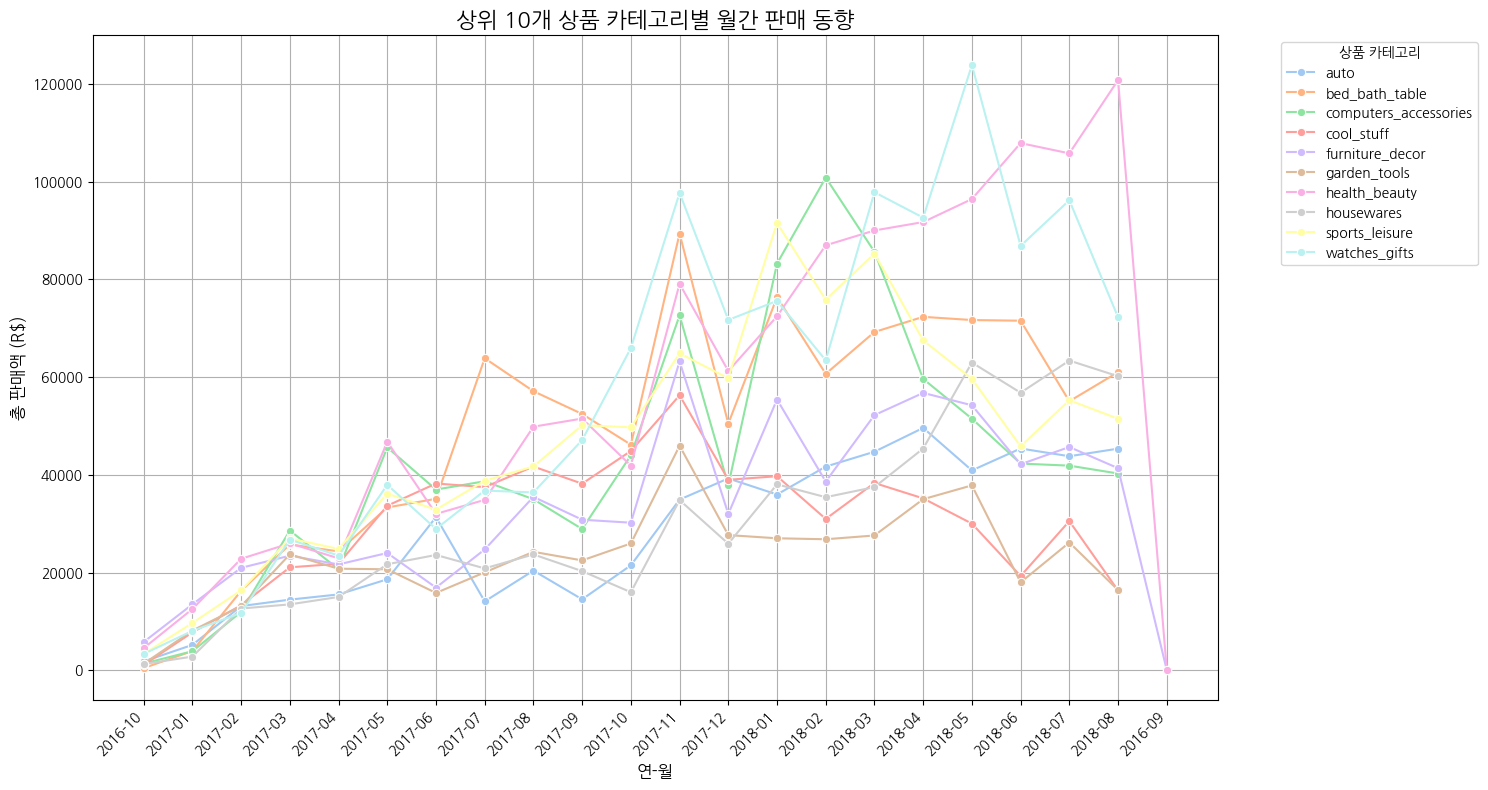

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the merged data
try:
    df_sales_analysis = pd.read_csv("df_sales_analysis.csv")
    df_sales_analysis['order_purchase_timestamp'] = pd.to_datetime(df_sales_analysis['order_purchase_timestamp'])

    # Aggregate total sales by month and product category
    df_sales_analysis['year_month'] = df_sales_analysis['order_purchase_timestamp'].dt.to_period('M')
    monthly_sales = df_sales_analysis.groupby(['product_category_name_english', 'year_month'])['price'].sum().reset_index()
    monthly_sales['year_month'] = monthly_sales['year_month'].astype(str)

    # Identify the top 10 categories by total sales
    top_10_categories = df_sales_analysis.groupby('product_category_name_english')['price'].sum().nlargest(10).index
    df_top_10_sales = monthly_sales[monthly_sales['product_category_name_english'].isin(top_10_categories)]

    # Create the line plot
    plt.figure(figsize=(15, 8))
    sns.lineplot(data=df_top_10_sales, x='year_month', y='price', hue='product_category_name_english', marker='o')

    # Add labels and title
    plt.title('상위 10개 상품 카테고리별 월간 판매 동향', fontsize=16)
    plt.xlabel('연-월', fontsize=12)
    plt.ylabel('총 판매액 (R$)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='상품 카테고리', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('category_sales_trends.png')

    # Save aggregated monthly sales data
    monthly_sales.to_csv('monthly_category_sales.csv', index=False)

except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure the files are uploaded or generated correctly.")

## 자유주제

In [24]:
import pandas as pd

# Load the necessary datasets for logistics analysis
try:
    df_orders = pd.read_csv("olist_orders_dataset.csv")
    df_reviews = pd.read_csv("olist_order_reviews_dataset.csv")
    df_customers = pd.read_csv("olist_customers_dataset.csv")

    # Merge orders and reviews on 'order_id'
    df_merged = pd.merge(df_orders, df_reviews, on='order_id', how='left')

    # Merge the result with customers on 'customer_id'
    df_final_logistics = pd.merge(df_merged, df_customers, on='customer_id', how='left')

    # Filter for only delivered orders to ensure accurate delivery time calculation
    df_final_logistics = df_final_logistics[df_final_logistics['order_status'] == 'delivered'].copy()

    # Convert date columns to datetime objects
    df_final_logistics['order_purchase_timestamp'] = pd.to_datetime(df_final_logistics['order_purchase_timestamp'])
    df_final_logistics['order_delivered_customer_date'] = pd.to_datetime(df_final_logistics['order_delivered_customer_date'])
    df_final_logistics['order_estimated_delivery_date'] = pd.to_datetime(df_final_logistics['order_estimated_delivery_date'])

    # Calculate actual delivery time and delay time
    df_final_logistics['delivery_time_days'] = (df_final_logistics['order_delivered_customer_date'] - df_final_logistics['order_purchase_timestamp']).dt.days
    df_final_logistics['delivery_delay_days'] = (df_final_logistics['order_delivered_customer_date'] - df_final_logistics['order_estimated_delivery_date']).dt.days

    # Save the final dataframe for the next step
    df_final_logistics.to_csv("df_logistics_analysis.csv", index=False)

    # Now, load the payment data for a new analysis
    df_payments = pd.read_csv("olist_order_payments_dataset.csv")

    # Group by payment type and sum the total payment value
    payment_distribution = df_payments.groupby('payment_type')['payment_value'].sum().sort_values(ascending=False).reset_index()

    # Print a summary of the merged and calculated data
    print("--- 배송 성과 지표 샘플 ---")
    print(df_final_logistics[['order_id', 'customer_state', 'review_score', 'delivery_time_days', 'delivery_delay_days']].head())

    # Print payment distribution
    print("\n--- 결제 수단별 총 판매액 ---")
    print(payment_distribution)

    # Save payment distribution data
    payment_distribution.to_csv('payment_distribution.csv', index=False)

except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure the files are uploaded correctly.")

--- 배송 성과 지표 샘플 ---
                           order_id customer_state  review_score  \
0  e481f51cbdc54678b7cc49136f2d6af7             SP           4.0   
1  53cdb2fc8bc7dce0b6741e2150273451             BA           4.0   
2  47770eb9100c2d0c44946d9cf07ec65d             GO           5.0   
3  949d5b44dbf5de918fe9c16f97b45f8a             RN           5.0   
4  ad21c59c0840e6cb83a9ceb5573f8159             SP           5.0   

   delivery_time_days  delivery_delay_days  
0                 8.0                 -8.0  
1                13.0                 -6.0  
2                 9.0                -18.0  
3                13.0                -13.0  
4                 2.0                -10.0  

--- 결제 수단별 총 판매액 ---
  payment_type  payment_value
0  credit_card    12542084.19
1       boleto     2869361.27
2      voucher      379436.87
3   debit_card      217989.79
4  not_defined           0.00


--- 리뷰 점수별 평균 배송 지연 (일) ---
   review_score  avg_delay_days  order_count
0           1.0           -4.05         9405
1           2.0           -8.63         2941
2           3.0          -10.78         7961
3           4.0          -12.38        18987
4           5.0          -13.39        57059

--- 지역별 배송 성과 및 평균 리뷰 점수 ---
   customer_state  avg_delivery_time_days  avg_delay_days  avg_review_score  \
25             SP                    8.30          -11.08              4.25   
18             RJ                   14.86          -11.75              3.96   
10             MG                   11.55          -13.26              4.19   
22             RS                   14.84          -13.91              4.19   
17             PR                   11.54          -13.30              4.24   
23             SC                   14.50          -11.49              4.13   
4              BA                   18.89          -10.79              3.93   
6              DF                   12.5

C:\Users\user\AppData\Local\Temp\ipykernel_13236\2118978837.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=delay_review_pivot, x='delay_status', y='review_score', palette='pastel') # 팔레트를 'pastel'로 변경


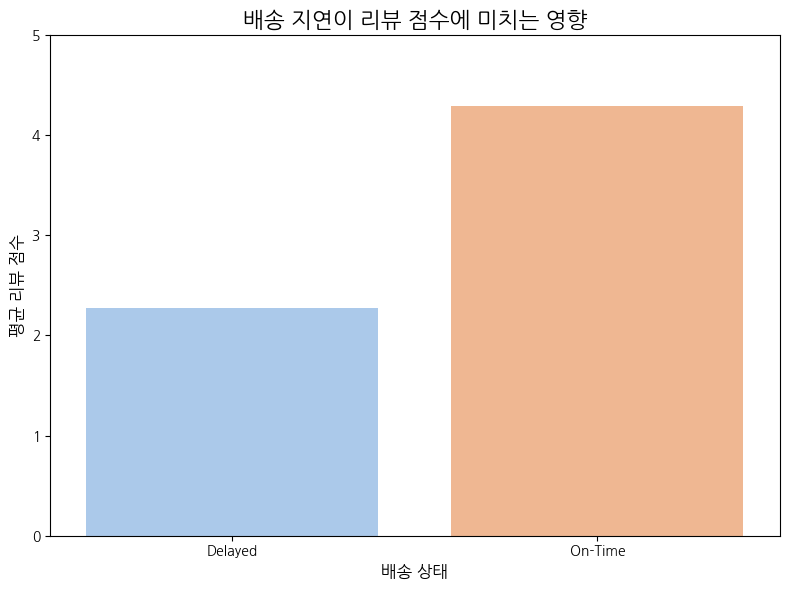

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the logistics data
try:
    df_logistics = pd.read_csv("df_logistics_analysis.csv")

    # Group by review score to analyze delivery delay's impact on satisfaction
    review_delay_impact = df_logistics.groupby('review_score')['delivery_delay_days'].agg(['mean', 'count']).round(2).reset_index()
    review_delay_impact.columns = ['review_score', 'avg_delay_days', 'order_count']
    print("--- 리뷰 점수별 평균 배송 지연 (일) ---")
    print(review_delay_impact)

    # Regional logistics performance analysis
    regional_performance = df_logistics.groupby('customer_state').agg(
        avg_delivery_time_days=('delivery_time_days', 'mean'),
        avg_delay_days=('delivery_delay_days', 'mean'),
        avg_review_score=('review_score', 'mean'),
        total_orders=('order_id', 'count')
    ).round(2).reset_index()
    regional_performance.sort_values(by='total_orders', ascending=False, inplace=True)
    print("\n--- 지역별 배송 성과 및 평균 리뷰 점수 ---")
    print(regional_performance.head(10))

    # Visualization: Impact of Delivery Delay on Review Score
    df_logistics['delay_status'] = np.where(df_logistics['delivery_delay_days'] > 0, 'Delayed', 'On-Time')
    delay_review_pivot = df_logistics.pivot_table(index='delay_status', values='review_score', aggfunc='mean').reset_index()

    plt.figure(figsize=(8, 6))
    sns.barplot(data=delay_review_pivot, x='delay_status', y='review_score', palette='pastel') # 팔레트를 'pastel'로 변경
    plt.title('배송 지연이 리뷰 점수에 미치는 영향', fontsize=16)
    plt.xlabel('배송 상태', fontsize=12)
    plt.ylabel('평균 리뷰 점수', fontsize=12)
    plt.ylim(0, 5)
    plt.tight_layout()
    plt.savefig('delay_impact_on_review_pastel.png') # 파일 이름 변경

except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure the files are uploaded or generated correctly.")